# Import library

In [1]:
import pandas as pd
from sklearn.decomposition import PCA as sklearnPCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from scipy import sparse
from sklearn.metrics import accuracy_score

# Read data

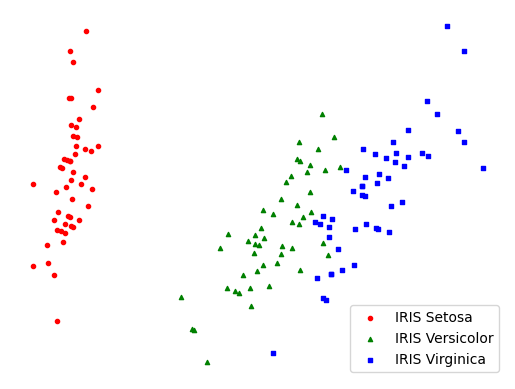

In [2]:
# import some data to play with
iris = datasets.load_iris()
X = iris.data[:, :4] # we take full 4 features
Y = iris.target
np.random.seed(2)
# Normalize data
X_norm = (X - X.min())/(X.max() - X.min())
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(X_norm))
plt.axis("off")
plt.scatter(transformed[Y==0][0], transformed[Y==0][1], s=9, label='IRIS Setosa',
c='red')
plt.scatter(transformed[Y==1][0], transformed[Y==1][1], s=9, label='IRIS Versicolor',
c='green', marker="^")

plt.scatter(transformed[Y==2][0], transformed[Y==2][1], s=9, label='IRIS Virginica',
c='blue', marker="s")
plt.legend()
plt.show()

# Split data to train data and validate data

In [3]:
print(X.shape[0])
X = np.concatenate((np.ones((1, X.shape[0])), X.T), axis = 0).T
train_data = X[:round(X.shape[0] * 4 / 5), :].T
train_label = Y[:round(Y.shape[0] * 4 / 5)]

validate_data = X[round(X.shape[0] * 4 / 5): , :].T
validate_label = Y[round(Y.shape[0] * 4 / 5):]

150


# Build method for model

In [4]:
def convert_labels(y, C):
    """
    convert 1d label to a matrix label: each column of this
    matrix coresponding to 1 element in y. In i-th column of Y,
    only one non-zeros element located in the y[i]-th position,
    and = 1 ex: y = [0, 2, 1, 0], and 3 classes then return

    [[1, 0, 0, 1],
    [0, 0, 1, 0],
    [0, 1, 0, 0]]
    """
    Y = sparse.coo_matrix((np.ones_like(y),
        (y, np.arange(len(y)))), shape = (C, len(y))).toarray()
    return Y

# Y = convert_labels(y, C)

def softmax_stable(Z):
    """

    Compute softmax values for each sets of scores in Z.
    each column of Z is a set of score.
    """
    e_Z = np.exp(Z - np.max(Z, axis = 0, keepdims = True))
    A = e_Z / e_Z.sum(axis = 0)
    return A

def softmax(Z):
    """
    #Compute softmax values for each sets of scores in V.
    #each column of V is a set of score.
    """
    e_Z = np.exp(Z)
    A = e_Z / e_Z.sum(axis = 0)
    return A

def softmax_regression(X, y, W_init, eta, tol = 1e-4, max_count = 10000):
    W = [W_init]
    C = W_init.shape[1]
    Y = convert_labels(y, C)
    it = 0
    N = X.shape[1]
    d = X.shape[0]

    count = 0
    check_w_after = 20
    while count < max_count:
        # mix data
        mix_id = np.random.permutation(N)
        for i in mix_id:
            xi = X[:, i].reshape(d, 1)
            yi = Y[:, i].reshape(C, 1)
            ai = softmax(np.dot(W[-1].T, xi))
            W_new = W[-1] + eta*xi.dot((yi - ai).T)
            count += 1
            # stopping criteria
            if count%check_w_after == 0:
                if np.linalg.norm(W_new - W[-check_w_after]) < tol:
                    return W
            W.append(W_new)
    return W

# cost or loss function
def cost(X, Y, W):
    A = softmax(W.T.dot(X))
    return -np.sum(Y*np.log(A))


# Predict that X belong to which class (1..C now indexed as 0..C-1 )
def pred(W, X):
    """
    predict output of each columns of X
    Class of each x_i is determined by location of max probability
    Note that class are indexed by [0, 1, 2, ...., C-1]
    """
    A = softmax_stable(W.T.dot(X))
    return np.argmax(A, axis = 0)

# W[-1] is the solution, W is all history of weights

# Print coef

In [5]:
eta = .05
d = train_data.shape[0]
W_init = np.random.randn(X.shape[1], 3)
W = softmax_regression(train_data, train_label, W_init, eta)
w_best = W[-1]
print(w_best)

[[-0.04036726  1.47075364 -4.03960715]
 [ 1.86887203  0.69598416 -3.55976834]
 [ 2.75945001 -0.09008414 -4.46972475]
 [-4.89964616  0.20894668  6.62535392]
 [-1.90273148 -3.20490534  4.57030908]]


# Predict validate data

In [6]:
y_pre = pred(w_best, validate_data)
print("accuracy score:\n", accuracy_score(y_pre, validate_label))

accuracy score:
 0.9666666666666667


# Predict with model sklearn

In [8]:
import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.datasets import load_iris

iris=load_iris()
X=iris.data # Observed variable
Y=iris.target # Dependent variable (label)

# Splitting Train and test Data
X_train,X_test,Y_train,Y_test=sklearn.model_selection.train_test_split(X,Y,test_size=0.2,
random_state=2)

sc=StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)
# Call to Logistic Regression Model - SAG: solving is based on Stochastic Average Gradient
lorg=LogisticRegression(multi_class='multinomial',solver='sag', max_iter=5000)
# and train model by Training Dataset
lorg.fit(X_train,Y_train)
# Then Predict the Test data
Y_pred=lorg.predict(X_test)
# for accuracy
from sklearn.metrics import accuracy_score
print("Accuracy score: ", accuracy_score(Y_test,Y_pred))
# for confusion matrix
from sklearn.metrics import confusion_matrix
cm=confusion_matrix(Y_test,Y_pred)
print("Confuse matrix: \n", cm)

Accuracy score:  0.9666666666666667
Confuse matrix: 
 [[14  0  0]
 [ 0  7  1]
 [ 0  0  8]]
